In [55]:
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F 

import visdom
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vis = visdom.Visdom(env="beta2")

Setting up a new session...


In [57]:
import os
os.getcwd()
from tqdm import tqdm
import matplotlib.pyplot as plt

In [59]:
class fxnnxc(nn.Module):
    def __init__(self):
        super(fxnnxc, self).__init__()
        self.in_channel = 1
        self.latent_dim = 10
        self.hidden_dims = [self.in_channel, 32, 64, 256]
        # build encoder
        modules = []
        #in_channel = self.in_channel
        for i in range(len(self.hidden_dims)-1):
            modules.append(
                nn.Sequential(
                    nn.Conv2d(self.hidden_dims[i], out_channels=self.hidden_dims[i+1],
                                kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(self.hidden_dims[i+1]),
                    nn.LeakyReLU()
                )
            )

        self.encoder = nn.Sequential(*modules)
        self.fc_mu  = nn.Linear(self.hidden_dims[-1]*16, self.latent_dim)
        self.fc_var = nn.Linear(self.hidden_dims[-1]*16, self.latent_dim)

        # build decoder
        modules = []
        self.decoder_input = nn.Linear(self.latent_dim, self.hidden_dims[-1]*16)
        for i in range(len(self.hidden_dims)-1,1,-1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(self.hidden_dims[i],
                                        self.hidden_dims[i-1],
                                        kernel_size=3,
                                        stride  = 2,
                                        padding=1,
                                        output_padding=1),
                    nn.BatchNorm2d(self.hidden_dims[i-1]),
                    nn.LeakyReLU()
                )
            )
        
        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(self.hidden_dims[1],
                                self.hidden_dims[1],
                                kernel_size=3,
                                stride=2,
                                padding=1,
                                output_padding=1),
            nn.BatchNorm2d(self.hidden_dims[1]),
            nn.LeakyReLU(),
            nn.Conv2d(self.hidden_dims[1], out_channels=self.hidden_dims[0],
                        kernel_size=3, padding=1),
            nn.Tanh())

    #encode
    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]
    
    #decode
    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, 256, 4,4)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)

        return [self.decode(z), input, mu, log_var]

    def loss_function(self, args, **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        beta = 2
        kld_weight = 0.005

        recons_loss = F.mse_loss(recons, input)
        kld_loss = torch.mean(-0.5 * torch.sum(1+ log_var - mu**2- log_var.exp(), dim=1), dim=0)

        loss = recons_loss + beta * kld_weight * kld_loss 
        return {"loss":loss, "Reconsturciton_loss": recons_loss, "KLD":kld_loss}

    def sample(self, num_samples:int, current_device:int, **kwargs)->torch.Tensor:
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(current_device)

        samples = self.decode(z)
        return samples
    
    def generate(self, x:torch.Tensor, **kwargs) ->torch.Tensor:
        return self.forward(x)[0]


In [61]:
#--------------------------------------------- file read
x_train = np.load("data/mnist_train.npy")
x_test  = np.load("data/mnist_test.npy")
y_train = np.load("data/mnist_train_target.npy")
y_test  = np.load("data/mnist_test_target.npy")
#--------------------------------------------- numpy to tensor
x_train  = torch.from_numpy(x_train).float()       #long으로 하면 loss 계산할 때 에러
x_test   = torch.from_numpy(x_test).float()
y_train  = torch.from_numpy(y_train).long()        #float으로 하면 loss 계산할 때 에러  
y_test   = torch.from_numpy(y_test).long()

#--------------------------------------------- data to dataset
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset  = torch.utils.data.TensorDataset(x_test,  y_test)

#--------------------------------------------- dataset to dataloader 
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=2)
                                    
test_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=2)                                 
                                    

In [63]:
model = fxnnxc().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

<Figure size 1440x288 with 0 Axes>

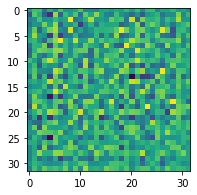

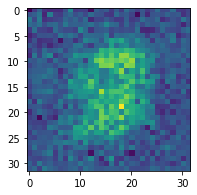

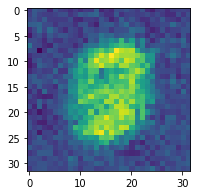

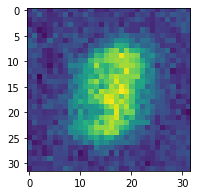

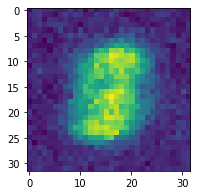

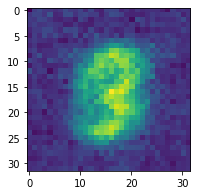

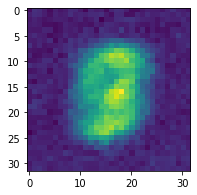

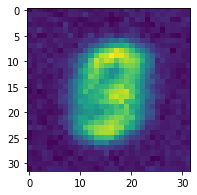

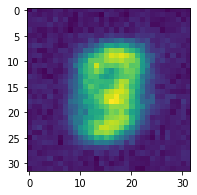

[WinError 10054] An existing connection was forcibly closed by the remote host
[WinError 10054] An existing connection was forcibly closed by the remote host
[WinError 10054] An existing connection was forcibly closed by the remote host
[WinError 10054] An existing connection was forcibly closed by the remote host
[WinError 10054] An existing connection was forcibly closed by the remote host
[WinError 10054] An existing connection was forcibly closed by the remote hostTraceback (most recent call last):
  File "C:\Users\beomj\anaconda3\envs\torch\lib\site-packages\urllib3\connectionpool.py", line 706, in urlopen
    chunked=chunked,
  File "C:\Users\beomj\anaconda3\envs\torch\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Users\beomj\anaconda3\envs\torch\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()

  File "C:\Use

KeyboardInterrupt: 

In [65]:
EPOCH = 1
img_cnt = 0
plt.figure(figsize=(20,4))
for t in range(EPOCH): # EPOCH
    for i, (sample, target) in enumerate(train_loader): #BATCH
        sample = sample/255
        sample = torch.nn.functional.pad(sample, ((2,2,2,2)), 'constant')
        sample = sample.unsqueeze(dim=1)
        sample = sample.to(device)
        target = target.to(device)

        y = model(sample)
        loss = model.loss_function(y)
        optimizer.zero_grad()
        loss['loss'].backward()
        optimizer.step()

        if i % 100 == 1:
            plt.figure(figsize=(3,3))
            plt.imshow(y[0][0,0,:,:].clone().detach().cpu())
            plt.show()
            img_cnt+=1

            #--------------- VISDOM 
        vis.line(X=[i], Y=[loss['loss'].item()], 
            win="loss", 
            update="append", 
            name=f"epoch {t+1}",
            opts=dict(showlegend=True, title='loss'))   
        vis.line(X=[i], Y=[loss['Reconsturciton_loss'].item()], 
            win="reconstruction_loss", 
            update="append", 
            name=f"epoch {t+1}",
            opts=dict(showlegend=True, title="recon"))   
        vis.line(X=[i], Y=[loss['KLD'].item()], 
            win="KLDivergence", 
            update="append", 
            name=f"epoch {t+1}",
            opts=dict(showlegend=True, title="KLD"))             

    #---------------------------------------------------

In [60]:

with torch.no_grad(): 
    for data in test_loader:
        sample, labels = data
        sample = sample/255
        sample = torch.nn.functional.pad(sample, ((2,2,2,2)), 'constant')
        sample = sample.unsqueeze(dim=1)
        sample = sample.to(device)  
        outputs = model(sample)
        break
        

[WinError 10061] No connection could be made because the target machine actively refused it
[WinError 10061] No connection could be made because the target machine actively refused it
[WinError 10061] No connection could be made because the target machine actively refused it
[WinError 10061] No connection could be made because the target machine actively refused it
[WinError 10061] No connection could be made because the target machine actively refused it
[WinError 10061] No connection could be made because the target machine actively refused it
[WinError 10061] No connection could be made because the target machine actively refused it
[WinError 10061] No connection could be made because the target machine actively refused it
[WinError 10061] No connection could be made because the target machine actively refused it


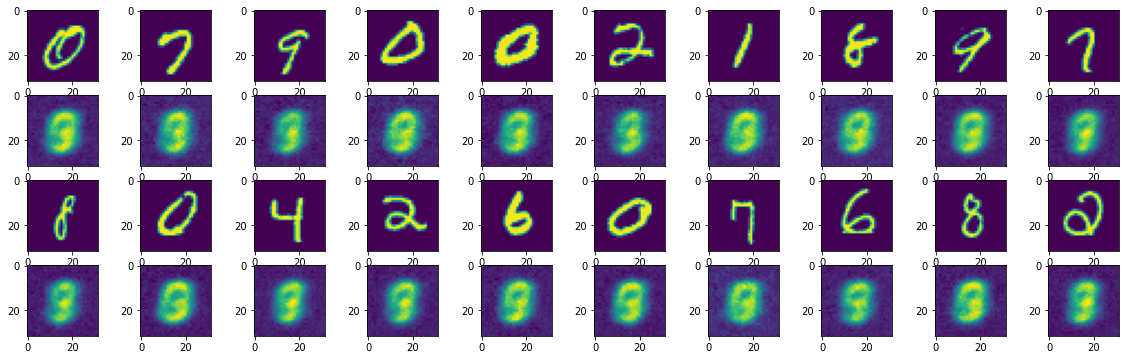

In [67]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,6))

for i in range(1, 11):
    plt.subplot(4,10,i )
    plt.imshow(sample[i,0,:,:].cpu())

for i in range(1, 11):
    plt.subplot(4,10,i+10)
    plt.imshow(outputs[0][i,0,:,:].cpu())

for i in range(1,11):
    plt.subplot(4,10,i+20 )
    plt.imshow(sample[i+10,0,:,:].cpu())

for i in range(1, 11):
    plt.subplot(4,10,i+30)
    plt.imshow(outputs[0][i+10,0,:,:].cpu())

plt.savefig('fig1.png', dpi=300)

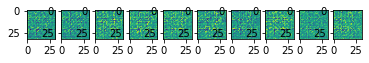

In [64]:
output = model.sample(10, device)
for i in range(1, 11):
    plt.subplot(1,10,i)
    plt.imshow(output[i-1,0,:,:].detach().cpu())